Along **`Practical Statistics for Data Scientists`** book 

Chapter 3 : Statistical Experiments and Significance Testing

<a id=top></a>
[Go to bottom](#bottom)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from scipy.stats import stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import os
import random

In [2]:
def populate_data(filename) :
    data_path = os.path.join(os.getcwd(), 'data') + '/' + filename
    df = pd.read_csv(data_path)
    print(df.info())
    print(df.head())
    return df

## Resampling
Boostrapping and Permutation test

- Bootstrapping : estimate the sampling distribution of a statistic or parameters by replicating samples with replacement n repeating times - not compensate for a small sample size nor create a new data but powerful tool for assessing the variability of a sample statistic 
- Permutation test : multiple samples are combined and the sampling may be done without replacement

In [3]:
loans_income = populate_data('loans_income.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   x       50000 non-null  int64
dtypes: int64(1)
memory usage: 390.8 KB
None
        x
0   67000
1   52000
2  100000
3   78762
4   37041


### Bootstrapping

In [4]:
results = []
for nrepeats in range(1000) :
    boot_sample = resample(loans_income, replace=True)
    results.append(boot_sample.median())

In [5]:
results = pd.Series(results)
results.shape

(1000,)

In [6]:
print('Bootstrap statistics : ')
print(f'Original: {loans_income.iloc[:,0].median()}')
print(f'bias: {results.mean() - loans_income.iloc[:,0].median()}')
print(f'std err: {results.std()}')

Bootstrap statistics : 
Original: 62000.0
bias: -84.59150000000227
std err: 233.51835731040708


The original estimate of the median is \\$62000. The boostrap distribution incidates that the estimate has a bias of about -\\$64 and a standard error of \\$209.

### Permutation Test
Practice with **Web Stickiness** example 

_A company wants to test which of two web presentations creates a better sales. Due to high value of the server being sold, sales are infrequent and the sales cycle is long; so the company will go with the results with a proxy variable. A selected metric is average session time, comparing page A to page B. The result is a total of 36 sessions for the two different presentations : 21 for page A and 15 for page B._

In [7]:
sessions_pages = populate_data('web_page_data.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Page    36 non-null     object 
 1   Time    36 non-null     float64
dtypes: float64(1), object(1)
memory usage: 704.0+ bytes
None
     Page  Time
0  Page A  0.21
1  Page B  2.53
2  Page A  0.35
3  Page B  0.71
4  Page A  0.67


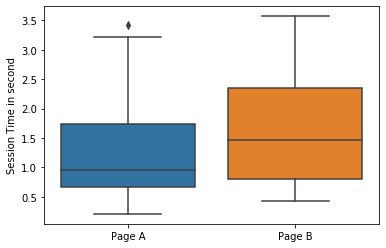

In [8]:
ax=sns.boxplot(data=sessions_pages, x='Page', y='Time')
ax.set_xlabel('')
ax.set_ylabel('Session Time in second')
plt.show()

In [9]:
mean_page_a = sessions_pages.query('Page=="Page A"').mean()
mean_page_b = sessions_pages.query('Page=="Page B"').mean()

In [10]:
obs_diff = (mean_page_b - mean_page_a)[0]
obs_diff

0.3566666666666669

The boxplot shows that page B held long sessions than page A. 0.35 more seconds on average.
So next is to confirm is the difference is statistically significant - by doing a permutation test.

how : combine all the session times together and then repeatedly shuffle. Divide them into a group of 21 (page A) and a group of 15 (page B).

In [11]:
def perm_test_two(x, nA, nB) :
    n = nA + nB
    idx_A = set(random.sample(range(n), nA))
    idx_B = set(range(n)) - idx_A
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()

In [12]:
perm_diff = [perm_test_two(sessions_pages.Time, 21, 15) for _ in range(1000)]

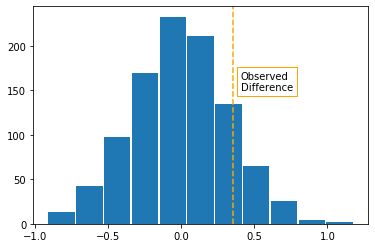

In [13]:
plt.hist(perm_diff, bins=11, rwidth=0.95)
plt.axvline(x=obs_diff, color='orange', ls='--')
plt.text(x=obs_diff+0.05, y=150, s='Observed\nDifference', 
         bbox={'facecolor':'white', 'edgecolor': 'orange'})
plt.show()

In [14]:
np.mean(perm_diff > obs_diff)  #p-value

0.134

11.5% chance that the mean difference of random permutations exceeds the observed difference in session time. This suggests that the observed difference between page A and B is within the range of chance variation and is not statistically significant.

---
## Statistical significance
Whether an experiment produces an outcome that is more extreme than random chance might do : the result is statistically significant if it is beyond the range of chance variation.

...and then p-value, alpha comes out! (with caution of Type 1 and 2 error)

### Pair-wise significance test

In [15]:
ecommerce_experiment = pd.DataFrame({'Converted':[200, 182], 
                                     'Not Converted':[23539, 22406]}, 
                                    index=['Price A', 'Price B'])

In [16]:
ecommerce_experiment = ecommerce_experiment.T
ecommerce_experiment

,Price A,Price B
Converted,200,182
Not Converted,23539,22406


In [17]:
conv_rate = ecommerce_experiment.loc['Converted'] / ecommerce_experiment.sum(axis=0)
conv_rate

Price A    0.008425
Price B    0.008057
dtype: float64

In [18]:
obs_diff_conv = conv_rate[0] - conv_rate[1]
obs_diff_conv

0.0003675791182059275

Difference in conversion rate is by 0.03678, which may be big in a high-volumn buiness, but how significant is this result?

It looks that sample size is enough but it actually is not, as the actual meaningful values (converted) are not big enough : test the difference by using resampling method.

Previously defined permutation test is useful for this case.

In [19]:
def full_perm_test(X, nA, nB, num_iter, obs_val) :
    perm_diff = [perm_test_two(X, nA, nB) for _ in range(num_iter)]
    print(f'Observed Difference : {obs_val:.4f}%')
    print('P-value: ', np.mean(perm_diff > obs_val))

    plt.hist(perm_diff, bins=11, rwidth=0.95)
    plt.axvline(x=obs_val, color='orange', ls='--')
    plt.show()

In [20]:
# re-create samples that replicates the dataset
conversion = [0] * ecommerce_experiment.iloc[1].sum()
conversion.extend([1] * ecommerce_experiment.iloc[0].sum())

In [21]:
conversion = pd.Series(conversion)

Observed Difference : 0.0004%
P-value:  0.329


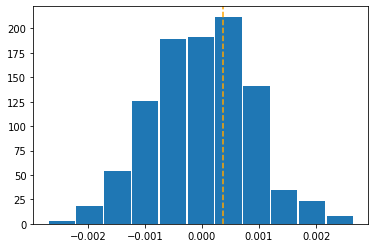

In [22]:
count_priceA = ecommerce_experiment['Price A'].sum()
count_priceB = ecommerce_experiment['Price B'].sum()

full_perm_test(conversion, count_priceA, count_priceB, 1000, obs_diff_conv)

P-value is 0.324, which means that we would expect to achieve a result as extreme as this, or a more extreme result, by random chance over 32% of the time. Conventionally alpha threshold is set at 1% or 5% level, and p-value above which indicates the outcome is not statistically significant. 

However, many argue (especially from academic side) p-value does not concretely prove as it seems to promise, and it is stressed that scientific conclusions or business/policy decisions should not be based only on a result drawn from p-value.

Also, practical significance must be considered. A small diference that has no practical meaning can be statistifcally significant for example.

### t-tests

Before the computing power grew, it was not feasible to do resampling (shuffling thousand+ times), so t-test provided a good approximation to the permutation distribution.

Unlike resampling where the scale of the data does not really matter, t-test requires a standardized form of the test statistics. **`scipy.stats.ttest_ind`** can be used : two-sided test for the null hypothesis that 2 independent samples have identical average values.

**Web Stickiness** example continues where the null hypothesis is the session time for Page A > Page B (one-sided test)

In [23]:
# assuming the population of the two samples have different variances
results = stats.ttest_ind(sessions_pages.query('Page == "Page A"').Time,
                          sessions_pages.query('Page == "Page B"').Time,
                          equal_var=False, nan_policy='raise')

In [24]:
results.pvalue / 2  # p-value for one-sided test

0.140762186228503

The earlier permutation test returned the p-value of 0.133, which is fairly close to the p-value from the t-test.

---
### Statistical testing among multiple groups
Not only A vs B. But A, B, C, D, ... : 

Doing multiple pair-wise testing will inflate alpha and make it more likely to be fooled by random chance. **ANOVA(Analysis of Variance)** is the procedure that tests for a statistically significant differencea among the groups. (pp120)

In [25]:
four_sessions = populate_data('four_sessions.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Page    20 non-null     object
 1   Time    20 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 448.0+ bytes
None
     Page  Time
0  Page 1   164
1  Page 2   178
2  Page 3   175
3  Page 4   155
4  Page 1   172


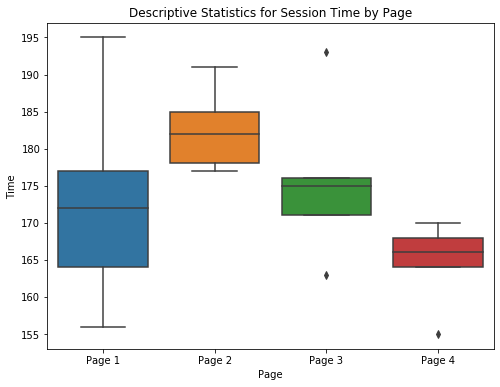

In [26]:
# Descriptive stats 
plt.figure(figsize=(8,6))
sns.boxplot(data=four_sessions, x='Page', y='Time')

plt.title('Descriptive Statistics for Session Time by Page')
plt.show()

Next, the question follows if the above result is statistically significant? In this case, [`np.random.permutation`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.permutation.html) method can help. Examples as below:

In [27]:
# Randomly permute a sequence, or return a permuted range
perm_a = np.random.permutation(10) # int
perm_b = np.random.permutation([12,58,39,10,27,98,75,36,85,19])
perm_a, perm_b

(array([9, 4, 7, 1, 8, 2, 5, 3, 6, 0]),
 array([85, 27, 58, 10, 12, 19, 98, 75, 36, 39]))

In [28]:
# Statistical testing 
obs_var = four_sessions.groupby('Page').mean().var()[0]

In [29]:
def perm_test_anova(df) :
    temp = df.copy()
    temp['Time'] = np.random.permutation(temp['Time'].values)
    return temp.groupby('Page').mean().var()[0]

In [30]:
# Iterate lots of times (i.e. 1000 iterations)
perm_var = [perm_test_anova(four_sessions) for _ in range(1000)]

In [31]:
# perm_var

Observed means:  [172.8 182.6 175.6 164.6]
Observed variance of means:  55.426666666666655
P-value:  0.087


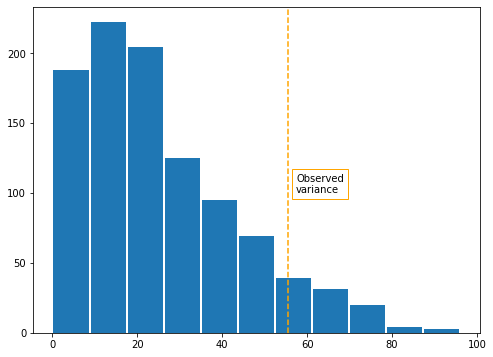

In [32]:
print('Observed means: ', four_sessions.groupby('Page').mean().values.ravel())
print('Observed variance of means: ', obs_var)
print('P-value: ', np.mean(perm_var > obs_var)) # note one-sided (variance)

plt.figure(figsize=(8,6))
plt.hist(perm_var, bins=11, rwidth=0.95)
plt.axvline(obs_var, ls='--', c='orange')
plt.text(x=obs_var+2, y=100, s='Observed\nvariance', 
         bbox={'facecolor':'white', 'edgecolor': 'orange'})

plt.show()

### F-statistic
Just like t-test used instead of a permutation test, there is a statistical test for ANOVA based on F-statistic : the ratio of the variance across group means to the variance due to the residual error. The higher the ratio, the more statistically significant.

**`Method 1`** The Statsmodel package provides ANOVA implementation as following, using R language style formulas. [Document](https://www.statsmodels.org/dev/example_formulas.html)

In [33]:
model = smf.ols('Time ~ Page', data=four_sessions).fit()

In [34]:
#print(model.summary())

In [35]:
anova_table = sm.stats.anova_lm(model, typ=1) # one-way anova
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
Page,3.0,831.4,277.133333,2.739825,0.077586
Residual,16.0,1618.4,101.150000,NaN,NaN


- df : degree of freedom
- sum_sq : sum of squares
- mean_sq : mean-squared deviations
- F : F-statistic

- Sum of squares 
    - for treatment (Page) : the sum of squared departures between the treatment means and the grand average.
    - for residuals : sum of squared difference between the individual observations and the treament means
    
- Mean squares (MS) is the sum of squares(SS) divided by degrees of freedom (df)
- F-statistic : MS(treatment) / MS (error)

**`Method 2`** scipy.stats.f_oneway

Assumption of the method for a valid p-value
1. The samples are independent.
2. Each sample is from a normally distributed population.
3. The population standard deviations of the groups are all equal.  This
   property is known as homoscedasticity.
  
**For Reference only** : Two-way ANOVA - when a second factor involved i.e. session time on weekend vs weekday 

#### Two-way anova only available with statsmodels
``` 
formula = 'len ~ C(supp) + C(dose) + C(supp):C(dose)'
model = ols(formula, data).fit()
aov_table = anova_lm(model, typ=2)
```

In [36]:
result_anova = stats.f_oneway(four_sessions.query('Page == "Page 1"').Time,
                              four_sessions.query('Page == "Page 2"').Time, 
                              four_sessions.query('Page == "Page 3"').Time,
                              four_sessions.query('Page == "Page 4"').Time)

In [37]:
result_anova # returns F-statistic and p-value

F_onewayResult(statistic=2.739825341901467, pvalue=0.0775862152580146)

---
### Chi-squre test
Similar to the test in F-statistic in that they both test multiple treaments(features) at once but Chi-square deals with **`counts`** rather than continous values.

$$R\ Squared = \chi^2 = \sum \frac {(O - E)^2}{E}$$

<center>, where O : Observed, E : Expected</center>

In [38]:
click_rates = populate_data('click_rates.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Headline  6 non-null      object
 1   Click     6 non-null      object
 2   Rate      6 non-null      int64 
dtypes: int64(1), object(2)
memory usage: 272.0+ bytes
None
     Headline     Click  Rate
0  Headline A     Click    14
1  Headline A  No-click   986
2  Headline B     Click     8
3  Headline B  No-click   992
4  Headline C     Click    12


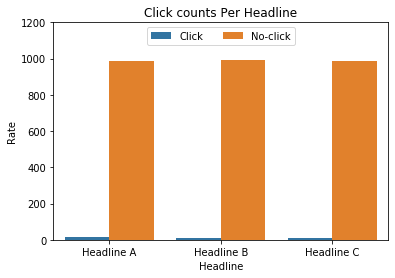

In [39]:
plt.figure(figsize=(6,4))
sns.barplot(x='Headline', y='Rate', hue='Click', data=click_rates)

plt.title('Click counts Per Headline')
plt.legend(loc='upper center', ncol=2)
plt.ylim((0,1200))
plt.show()

Chi square is to test how well it fits some **expected** distribution.

In [40]:
# Calculating expected click values 
# when null is true (all Headline share the same click counts)
expected_rate = ( click_rates.groupby('Click').sum() 
                 / click_rates.groupby('Click').sum().sum() * 1000 )
expected_rate_dict = expected_rate['Rate'].to_dict()
expected_rate_dict

{'Click': 11.333333333333334, 'No-click': 988.6666666666667}

In [41]:
click_rates['Expected'] = click_rates['Click'].map(expected_rate_dict)
click_rates.rename(columns={'Rate':'Observed'}, inplace=True)

Calculating R sqaured

In [42]:
observed = click_rates['Observed']
expected = click_rates['Expected']  # percentage

click_rates['R_Squared'] = np.power((observed - expected), 2) / expected

In [43]:
click_rates

,Headline,Click,Observed,Expected,R_Squared
0,Headline A,Click,14,11.333333,0.627451
1,Headline A,No-click,986,988.666667,0.007193
2,Headline B,Click,8,11.333333,0.980392
3,Headline B,No-click,992,988.666667,0.011238
4,Headline C,Click,12,11.333333,0.039216
5,Headline C,No-click,988,988.666667,0.000450


The chi-square statistic is defined as the sume of the R_squared across all values in the matrix.


$$ X = \sum_{i}^{r}\sum_{j}^{c} R^2$$
<center>where r and c are the number of rows and columns repectively</center>

In [44]:
chi_square_statistic = click_rates.R_Squared.sum() # chi-square statistic 
df = ( click_rates['Headline'].nunique() - 1 ) * ( click_rates['Click'].nunique() - 1 )

chi_square_statistic, df

(1.6659394708658914, 2)

Easier way with a scipy package

In [45]:
stats.chisquare(observed, expected)

Power_divergenceResult(statistic=1.6659394708658914, pvalue=0.8931625552280715)

---
### Chi-square test with resampling algorithm

In [46]:
def chi2_test(observed, expected) :
    # return sum of squares (chi-statistic)
    statistic, pvalue = stats.chisquare(observed, expected)
    return statistic

In [47]:
click_rates.groupby('Click').sum().Observed

Click
Click         34
No-click    2966
Name: Observed, dtype: int64

In [48]:
# click : 1, no-click : 0
# Populate random click vs no-click
rand_click = [1] * 34
rand_click.extend([0] * 2966)
random.shuffle(rand_click)

In [49]:
# observed 
observed = click_rates['Observed']

# expected
expected = [34/3, 2966/3] * 3

# observed chi2
obs_chi2 = chi2_test(observed, expected)

In [50]:
obs_chi2

1.6659394708658917

In [51]:
def perm_test_chi2(values=rand_click) :
    
    # observed - 3 headlines x 1000  
    # observed clicks
    observed = [sum(random.sample(rand_click, 1000)),
                sum(random.sample(rand_click, 1000)),
                sum(random.sample(rand_click, 1000))]
    # adding observed no-clicks
    observed.extend([1000 - count for count in observed])
    
    expected = [34/3] * 3
    expected.extend([2966/3] * 3)
    
    return chi2_test(observed, expected)

In [52]:
perm_chi2_click = [perm_test_chi2() for _ in range(1000)] # calculate sum of squares

In [53]:
perm_pval = np.mean(perm_chi2_click > obs_chi2)

In [54]:
perm_pval # p-value

0.477

In [55]:
click_rates

,Headline,Click,Observed,Expected,R_Squared
0,Headline A,Click,14,11.333333,0.627451
1,Headline A,No-click,986,988.666667,0.007193
2,Headline B,Click,8,11.333333,0.980392
3,Headline B,No-click,992,988.666667,0.011238
4,Headline C,Click,12,11.333333,0.039216
5,Headline C,No-click,988,988.666667,0.000450


P-value from the permutation test returned 0.477 as opposed to 0.89 from the earlier chi-test.

The `click_rates` dataset does not contain enough data for click counts, which suggests resampling method is more likely to produce a more accurate p-value.

---
## Effect size and sample size
- What is the minimum size of the effect to detect in a stastical test (i.e. a 20% improvenment in click rates)
- **Power** : The probability of detecting a given effect size with a given sample size

For example, suppose current click-through rates are about 1.1% and I am seeking a 10% uplift to 1.21%.

In [2]:
# Finding the effect size for a test of two proportional values
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011) 
effect_size

0.01029785095103608

In [4]:
# Power calculation for a t-test 
power_analysis = sm.stats.TTestIndPower()

In [5]:
# Find the desired sample size to obtain for a one-sided test
# Suppose that we want a power of 80%, given 95% confidence level
result = power_analysis.solve_power(effect_size=effect_size, 
                                    alpha=0.05,
                                    power=0.8, alternative='larger')

In [7]:
print(f'Sample size: {result}')

Sample size: 116602.39258799309


For a one-side ttest with the effect size of 0.0103 (the current click-through rates are about 1.1% with 10% uplift to desire), I need to achieve at least 116603 sample size for a power of 80% given 95% confidence level.

In summary, to find out how big a sample size I need requires :
- the minimum size of the effect that I want to detect
- the required probability of detecting the desired effect size (power)
- the significance level (alpha) at which the test will be conducted

<a id=bottom></a>
[Go to top](#top)